In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
import os
encoding = '2345678bcdefgmnpwxy'
freq = [0]*len(encoding)

class Captcha(torch.utils.data.Dataset):
    def __init__(self, transform):
        self.img_list = []
        self.label_list = []
        self.transform = transform
        for root, dirs, files in os.walk('samples'):
            if root == 'samples':
                self.img_list.extend(files)
                for f in files:
                    label = []
                    for i in range(5):
                        label.append(encoding.index(f[i]))
                        freq[encoding.index(f[i])]+=1
                    self.label_list.append(label)
        
    def __getitem__(self, index):
        prefix = 'samples/'
        img = Image.open(prefix+self.img_list[index])
        return {
            'img': self.transform(img),
            'label': embedding(self.label_list[index])
        }
    def __len__(self):
        return len(self.img_list)

In [2]:
def embedding(label):
    embed = []
    for l in label:
        e = [0]*len(encoding)
        e[l] = 1
        embed.extend(e)
    return torch.tensor(embed)
    
from torchvision import transforms
image_size = 128
latent_dim = 500
transform = transforms.Compose([
                transforms.Resize((int(image_size/4), image_size)),
                transforms.Grayscale(),
                transforms.Pad((0, int(image_size*3/8), 0, int(image_size*3/8))),
                transforms.ToTensor()])

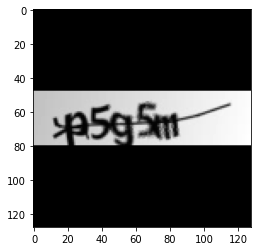

torch.Size([1, 128, 128])
Label encoding:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
Number of data: 1070


In [3]:
import matplotlib.pyplot as plt
dataset = Captcha(transform)
plt.imshow(dataset[0]['img'].permute(1, 2, 0), cmap='gray')
plt.show()
print(dataset[0]['img'].size())
print('Label encoding: ', dataset[0]['label'])
print("Number of data:", len(dataset))

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim+len(encoding)*5, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z, c):
        out = self.l1(torch.cat((z, c), 1))
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = image_size // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2 + len(encoding)*5, 1)

    def forward(self, img, c):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(torch.cat((out, c), 1))

        return validity

In [5]:
# Train duration
start_epoch, max_epoch = 1, 2000
log_step = max_epoch/10

# Loss function
adversarial_loss = torch.nn.MSELoss().cuda()

# Initialize generator and discriminator
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

from torch.utils.data import DataLoader
BATCH_SIZE = 128
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch: [200/2000] Loss_D: 0.2353 Loss_G: 0.2402


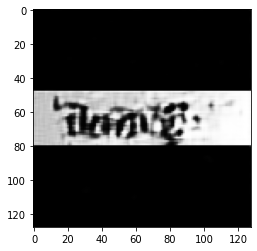

Epoch: [400/2000] Loss_D: 0.2533 Loss_G: 0.2075


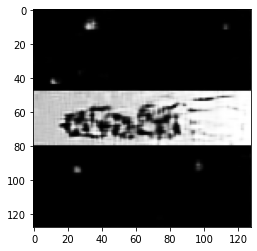

Epoch: [600/2000] Loss_D: 0.2463 Loss_G: 0.3153


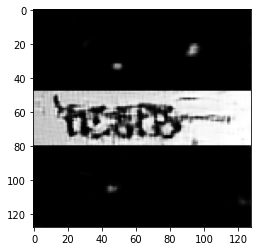

Epoch: [800/2000] Loss_D: 0.1935 Loss_G: 0.5444


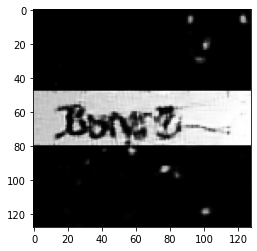

Epoch: [1000/2000] Loss_D: 0.1794 Loss_G: 0.4124


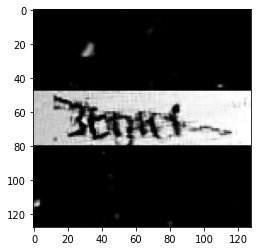

Epoch: [1200/2000] Loss_D: 0.1495 Loss_G: 0.4623


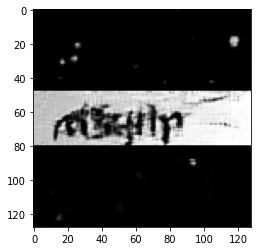

Epoch: [1400/2000] Loss_D: 0.0887 Loss_G: 0.5480


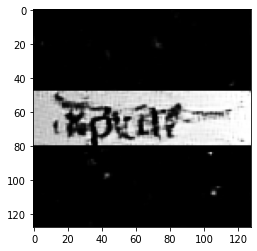

Epoch: [1600/2000] Loss_D: 0.1354 Loss_G: 0.5716


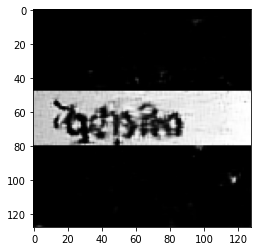

Epoch: [1800/2000] Loss_D: 0.0872 Loss_G: 0.7338


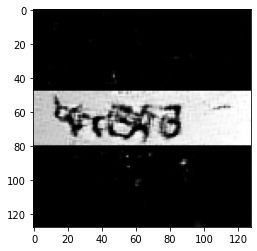

Epoch: [2000/2000] Loss_D: 0.0579 Loss_G: 0.9358


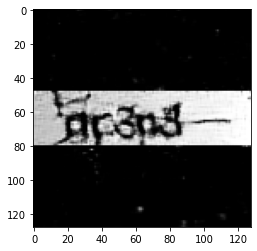

In [6]:
for epoch in range(start_epoch, max_epoch + 1):
    for i, data in enumerate(dataloader):    
        real_img = data['img'].cuda()
        c = data['label'].cuda()
        valid = torch.ones((real_img.size(0), 1), device='cuda', requires_grad=False).float()
        fake = torch.zeros((real_img.size(0), 1), device='cuda', requires_grad=False).float()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn(BATCH_SIZE, latent_dim).cuda()
        fake_img = generator(z, c)
        g_loss = adversarial_loss(discriminator(fake_img, c), valid)
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_img, c), valid)
        fake_loss = adversarial_loss(discriminator(fake_img.detach(), c), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        if epoch % log_step == 0 and i == 0:
            print('Epoch: [{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format(
                epoch, max_epoch,
                d_loss.item(), g_loss.item()
            ))
            plt.imshow(fake_img[0].cpu().detach().permute(1, 2, 0), cmap='gray')
            plt.show()
        

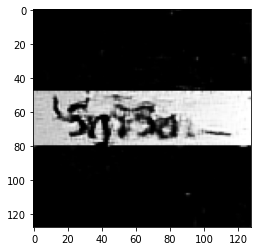

In [28]:
with torch.no_grad():
    z = torch.randn(1, latent_dim).cuda()
    c = torch.unsqueeze(embedding([14, 14, 14, 14, 14]), 0).cuda()
    fake_img = generator(z, c)
    
    plt.imshow(fake_img[0].cpu().detach().permute(1, 2, 0), cmap='gray')
    plt.show()